<a href="https://colab.research.google.com/github/AfsanehHabibi/reddit-conversation-quality/blob/main/Conversation_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install anytree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 876.5 kB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_path = "/content/drive/MyDrive/University/RedditData/"

In [5]:
import pickle

with open(f"{base_path}conversations_with_features_dataframe.pkl", 'rb') as file:
    df = pickle.load(file)

In [10]:
df.head()

,id,conversation_id,reply_to,readability,evidence,has_reasoning,politensess,relatedness,subjectivity,polarity,new_readability,norm_readability,norm_politeness
0,xyt38s,xyt38s,None,-0.5,0.5,0,0.095238,NaN,0.532381,0.224286,-0.5,0.95,0.117647
1,iromk5a,xyt38s,xyt38s,-0.5,0.5,0,0.095238,0.887727,0.532381,0.224286,-0.5,0.95,0.117647
2,irpc624,xyt38s,xyt38s,-4.5,0.5,0,0.000000,0.031587,0.000000,0.000000,-4.5,0.55,0.000000
3,irp3pvs,xyt38s,xyt38s,-5.5,0.0,0,0.047619,0.000000,0.400000,0.800000,-5.5,0.45,0.058824
4,xyt38b,xyt38b,None,-2.5,0.5,1,0.380952,NaN,0.415179,0.015476,-2.5,0.75,0.470588


Number of rows with non-NaN values in both 'mean_relatedness' and 'relatedness': 135904


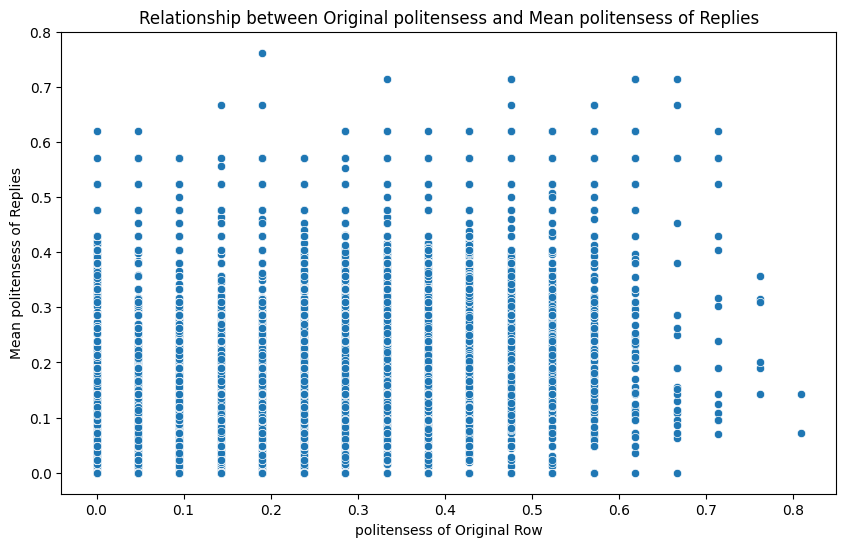

Number of rows with non-NaN values in both 'mean_relatedness' and 'relatedness': 116376


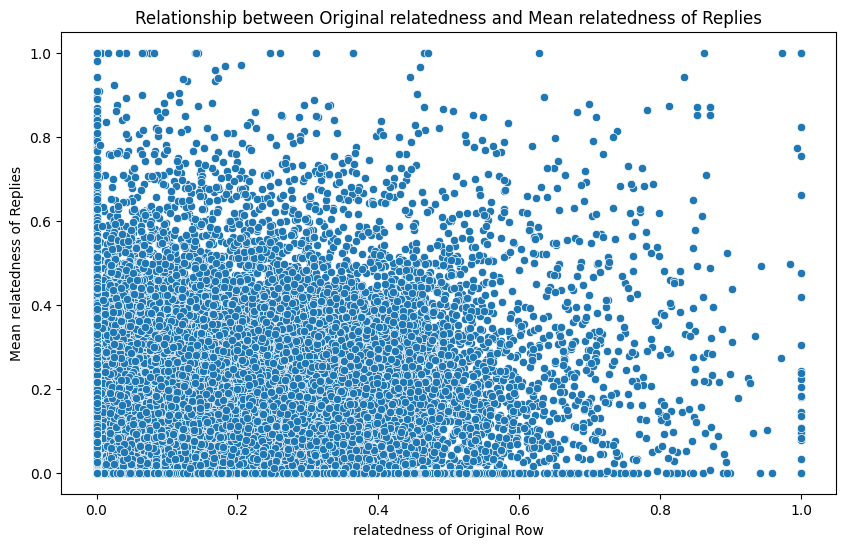

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def mean_column_politeness(df, column_name):
    # Create a new DataFrame with the mean politeness of replies for each original row
    replies_df = df.loc[df['reply_to'].notnull()]
    mean_politeness = replies_df.groupby('reply_to')[column_name].mean()

    # Merge the original rows with the mean politeness of replies
    df = df.merge(mean_politeness.rename('mean_' + column_name), left_on='id', right_index=True, how='left')

    # Plot the relationship between the politeness of the original row and the mean politeness of replies
    non_nan_count = df[(df['mean_' + column_name].notnull()) & (df[column_name].notnull())].shape[0]
    print(f"Number of rows with non-NaN values in both 'mean_relatedness' and 'relatedness': {non_nan_count}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=column_name, y='mean_' + column_name, data=df)
    plt.xlabel(f'{column_name} of Original Row')
    plt.ylabel(f'Mean {column_name} of Replies')
    plt.title(f'Relationship between Original {column_name} and Mean {column_name} of Replies')
    plt.show()

# Assume df is your DataFrame and 'id', 'reply_to', and 'politeness' are columns
mean_column_politeness(df, 'politensess')
mean_column_politeness(df, 'relatedness')
